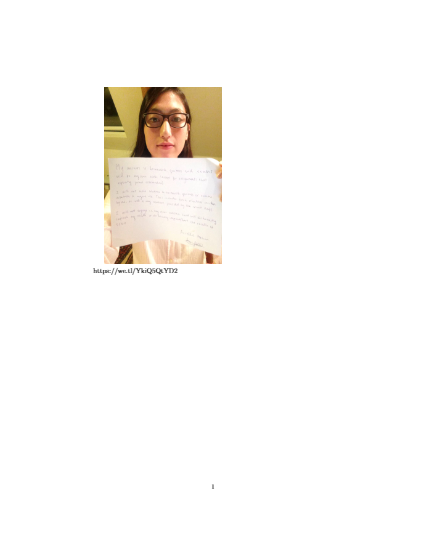

In [328]:
import pandas as pd
import nltk
from collections import Counter
from collections import Counter,defaultdict
from bs4 import BeautifulSoup
import os
import glob2 as glob
from __future__ import division
from nltk.corpus import stopwords
from IPython.display import Image
import numpy as np
import math
Image('selfie.png', width = 3000, height = 3000)

### 1.Normalize the values for "ministerie" and choose 10 ministeries to work with.

In [331]:
# Code Cell
names = ['jaar', 'partij', 'titel', 'vraag', 'antwoord', 'ministerie']

kvrdf = pd.read_csv('KVR.csv.gz',
                   compression = 'gzip',
                   sep = '\t',
                   index_col = 0,
                   names = names
                   )
for kolom in names[1:]:
    kvrdf[kolom]= kvrdf[kolom].astype(str)

print('total amount of categories with differrent names to be mormalised',
      len(kvrdf.ministerie.unique()))   

# normalization first run, lowercasing
for i in range(len(kvrdf.ministerie)):
    kvrdf.ministerie[i] = kvrdf.ministerie[i].lower()
    
# normalization second run, abbreviations and labeling
namen = ['jus', 'vws', 'buza', 'vw', 'szw', 'ocw', 'vrom',
         'fin', 'ez', 'bzk', 'def', 'lnv', 'bvk' 'vzi', 'mp',
         'ows', 'gsi', 'az', 'wwi', 'jg']

selectie_mins = ['jus', 'fin', 'buza', 'biza', 'lnv',
                 'vzi', 'def', 'az', 'vrom', 'jg']

class_inv = {0:'jus', 1:'fin', 2:'buza' ,  3:'biza' ,  4:'lnv'  ,  5:'vzi'  ,  6:'def'  ,  7:'az'  ,  8:'vwi'  ,  9:'jg'}

mins = {'justitie':'jus', 'financ':'fin', 'buitenl':'buza',
        'binnenl':'biza', 'landbo':'lnv',
        'vreemdel':'vzi', 'defens':'def', 'algeme':'az',
        'volkshuis':'vrom', 'jeugd':'jg'}

m, a, hi, labels=0, 0, True, []
for j in range(len(kvrdf.ministerie)):
    j = kvrdf.ministerie[j]
    test = j
    #print('j is:', j)
    while hi:
        for i in mins:        
            if i in j:
                j = mins[i]
                #print(j +'\n', 'a is:', a)
                hi = False
            elif mins[i] in j:
                j = mins[i]
                #print(j +'\n', 'a is:', a)
                hi = False
            #else:
            #    print(j'a is:', a, '\n')
        hi = False
    if test == j:
        j = 'anders'
        #a += 1
        #break
    #print('j is:', j)
    labels.append(j)
    hi = True
kvrdf.ministerie = labels #assign labels to all chamber questions

# take out all irrelevant texts corresponding to other ministries (reduces dimensionality of dataset drastically)
kvrdf = kvrdf[kvrdf.ministerie != 'anders']
    

total amount of categories with differrent names to be mormalised 429


We have reduced the Corpus size from >40k documents to about 16k documents by leaving out all questions unrelated to any of the ministries chosen to work with. 

### 2. Implement the two algorithms in Fig MRS.13.2, using your earlier code for creating term and document frequencies. It might be easier to use the representation and formula given in MRS section 13.4.1.

In [458]:
# MakeAnInvertedIndex (exercises week 1)
def MakeAnInvertedIndex(file):
    # Given algorithm for making an iverted index
    def index_collection_2(file):
        MyIndex = defaultdict(Counter) # initialize MyIndex
        for i in range(file.shape[0]):  # loop over each file
            fileIndex = file.index[i]
            text = [w for w in nltk.word_tokenize(' '.join(file.iloc[i, :].values).lower()) if w not in set(stopwords.words('dutch'))]   # tokenize, lower case
            
            for w in text:  # update MyIndex with each token 
                MyIndex[w][fileIndex]+=1         
        return MyIndex;
    
    # this function includes stuff that should be changed in the inverted index
    def clean_up(d) :
        d.pop('(')
        d.pop(')')
        d.pop(',')
        d.pop('.')
        return d
    
    # of how many works of shakespeare does the corpus consist?
    def nr_docs(DD):
        return DD.shape[0]
    
    # document frequency function per term returns one integer 
    def df_t(t, dic): 
        return len(dic[t].keys())

    # corpus/collection frequency per term returns one integer: 
    def cf_t(t, dic):
        return sum(dic[t].values())

    # option b, add values df and cf to key-value pair
    def augmented_index(index):
        return {t: [index[t], df_t(t, index), cf_t(t, index)] for t in index}
    
    return augmented_index(clean_up(index_collection_2(file))), nr_docs(DD)

def TrainMultinomialNB(CC, DD):
    V, N = MakeAnInvertedIndex(kvrdf)
    B = len(V)
    prior, condprob = np.zeros((len(CC))), np.zeros((len(V), len(CC)))
    
    def Count_docs_in_class(DD, c):
        DD_c = DD[DD.ministerie == c]
        return [DD_c.shape[0], DD_c]
    
    def Concatenate_text_of_all_docs_in_class(DD, c):
        text_c = ' '.join(['\n'.join(list(DD.jaar)), ' '.join(list(DD.partij)), ' '.join(list(DD.titel)), ' '.join(list(DD.vraag)), ' '.join(list(DD.antwoord))])
        return text_c, Counter([w for w in nltk.word_tokenize(text_c)])
    
    def CountTokensOfTerm(inv_index_text_c, t):        
        return inv_index_text_c[t], sum(inv_index_text_c.values())
    
    keys_V = list(V.keys())
    # start algorithm   
    for c in CC:
        j_c = CC.index(c)
        [N_c, DD_c] = Count_docs_in_class(DD, c)
        prior[j_c] = N_c / N
        text_c, inv_index_c = Concatenate_text_of_all_docs_in_class(DD_c, c)
        
        # Compute Bayesian probabilities for term counts in class corpuses
        
        for t in V:
            i_t = keys_V.index(t) # row index 
            T_ct, length_text_c = CountTokensOfTerm(inv_index_c, t) # # times token/term t appears in corpus of class c
            #print('we are working in class {} and term {}'.format(c, t)) 
            condprob[i_t, j_c] = (T_ct + 1) / (len(text_c) + B) # compute conditional probabilities of term t given class c       
    return V, prior, condprob

def ApplyMultinomialNB(CC, V, prior, condprob, d):
    
    score = np.zeros((len(CC)))
    W = {t : V[t][0][d] for t in V if V[t][0][d] != 0}  # W is an inverted index of document d only
    keys_V = list(V.keys())
    for c in CC:
        j_c = CC.index(c) # column index
        #print('j_c is {}'.format(j_c)) # shit wasn't working
        print(prior[j_c])
        if prior[j_c] < 0.005:
            prior[j_c] = 0.005
        score[j_c] = math.log(prior[j_c]) 
        for t in W:
            i_t = keys_V.index(t) # row index
            score[j_c] += math.log(condprob[i_t][j_c])
    score = list(score)
    return score.index(max(score))


In the previous cell both the training and testing naive Bayes algorithms were implemented. In the next question we'll really train and test it. 

### 3. On this collection, train NB text classifiers for 10 different classes with enough and interesting data.

In [459]:
# Let's start by splitting test and training data into 1:4 ratio.
def split_train_test(DD):
    return DD[: int(DD.shape[0] / 5)], DD[int(1 + DD.shape[0] / 5) :]



# this is for the end
kvrdf = kvrdf[:500]
Test_X, Train_X = split_train_test(kvrdf)
DD = Train_X
CC = selectie_mins
# for the test set, let's drop the class label
Labels = Test_X.ministerie
Test_X.drop('ministerie', axis=1) # drop enntire column 

# Ready... set... TRAIN
V, prior, condprob = TrainMultinomialNB(CC, DD)

# Ready... set... TEST
testing = [ApplyMultinomialNB(CC, V, prior, condprob, d) for d in Test_X.index]



0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.0
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.0
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.01002506265664160

0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.09523809523809523
0.07769423558897243
0.005
0.07268170426065163
0.010025062656641603
0.14536340852130325
0.005
0.3508771929824561
0.07017543859649122
0.17794486215538846
0.095238

Here I'll write a conclusion about what I did in question 3

### 4. Compute for each term and each of your 10 classes its utility for that class using mutual information